In [154]:
from sklearn.preprocessing import StandardScaler
import h5py
import os
from scipy.signal import resample
import numpy as np
import random as python_random
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# If you want to ensure reproducibility across folds, you might want to set random seeds for NumPy, TensorFlow, or any other libraries you're using.
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name


task_types = {
    'rest': 0,
    'task_motor': 1,
    'task_story': 2,
    'task_working': 3
}

downsample_factor = 4  #

def downsample(normalized_data):
    # How to know that we're not having a negative impact on the accuracy
    # Every file corresponds to a duration of approximately 17.5 seconds.
    #  print(35624 / 2034) 

    original_sample_rate = 2034
    target_sample_rate = 100  # Choose your desired target sample rate

    # Calculate the new number of time points based on the target sample rate
    new_num_time_points = int(
        normalized_data.shape[1] * target_sample_rate / original_sample_rate)

    # Perform downsampling
    return resample(normalized_data, new_num_time_points, axis=1)


def load_data(category_type, data_type):
    all_data = []
    labels = []

    # Define the base directory
    folder_path = f"data/{category_type}/{data_type}"

    # List all files in the directory
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

    for filename in file_names:
        full_path = os.path.join(folder_path, filename)
        with h5py.File(full_path, 'r') as file:
            
            dataset_name = get_dataset_name(full_path)
            data = file.get(dataset_name)[()]

            downsampled_data = data[:, ::downsample_factor]

            scaler = StandardScaler()

            X_scaled = scaler.fit_transform(
                downsampled_data.reshape(-1, downsampled_data.shape[-1])).reshape(downsampled_data.shape)
        
            all_data.append(X_scaled)

            # Extract task type and label
            if filename.startswith('task'):
                # Joins 'task' and the next word
                task_type = '_'.join(filename.split('_')[:2])
            else:
                task_type = filename.split('_')[0]
            # Default to -1 if task type not found
            label = task_types.get(task_type, -1)
            labels.append(label)
    return (all_data, labels)

# Data exploration / Preprocessing
Begin by exploring a few examples of the data. Visualize time-series data from individual sensors to get a sense of the patterns and variability

In [155]:
# Update this to work on cross or intra subject
category_type = 'Intra' # or Cross

if category_type == 'Intra':
  train_data, train_labels = load_data(category_type, 'train')
  test_data, test_labels = load_data(category_type, 'test')
else:
  train_data, train_labels = load_data(category_type, 'train')
  test1_data, test1_labels = load_data(category_type, 'test1')
  test2_data, test2_labels = load_data(category_type, 'test2')
  test3_data, test3_labels = load_data(category_type, 'test3')
  
  test_labels = np.stack(np.concatenate((test1_labels, test2_labels, test3_labels), axis=0), axis=0)
  test_data = np.stack(np.concatenate((test1_data, test2_data, test3_data), axis=0), axis=0)

# train_data are vertically stacked
train_data = np.stack(train_data, axis=0)
test_data = np.stack(test_data, axis=0)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# train
print(train_data.shape)
print(train_labels.shape)
# test
print(test_data.shape)
print(test_labels.shape)


one_hot_labels = to_categorical(train_labels, num_classes=4)
one_hot_test_labels = to_categorical(test_labels, num_classes=4)
print(one_hot_labels.shape)
print(one_hot_test_labels.shape)

(32, 248, 8906)
(32,)
(8, 248, 8906)
(8,)
(32, 4)
(8, 4)


# Model Architecture:

Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs) are often used for time-series data like MEG.

The layers are as follows:

in summary, the model is a sequential neural network with two LSTM layers followed by dropout layers, and finally, a dense layer for classification with a softmax activation. This architecture is commonly used for sequence-based classification tasks. Adjustments to hidden_size, dropout, and other hyperparameters would affect the performance.

In [148]:
loss = 'categorical_crossentropy'

def init_model(input_shape, hidden_size, dropout=0.2):
    model = Sequential([
        LSTM(hidden_size, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(hidden_size),
        Dropout(dropout),
        Dense(units=4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    return model


# input_shape is a tuple representing the shape of your input data, e.g., (sequence_length, input_features)
sequence_length = 248
input_features = 8906
input_shape = (sequence_length, input_features)
#  `hidden_size`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
hidden_size = 50
dropout = 0.2
model = init_model(input_shape=input_shape, hidden_size=hidden_size, dropout=dropout)
#print(model.summary())

# Model Training:

Train your model using the training set. Monitor the training process for potential overfitting or underfitting. Adjust hyperparameters as needed.

data and training hyparameters
* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.

In [157]:
# training params
# If you want to ensure reproducibility across folds, you might want to set random seeds for NumPy, TensorFlow, or any other libraries you're using.
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)
# loss and optimization functions
lr = 0.001


# Create an optimizer with the specified learning rate
# optimizer = Adam(learning_rate=lr)

# for logging
verbose = 0

# how many times the entire training dataset is passed forward and backward through the neural network
epochs = 15

# The dataset is split into 5 folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_scores = []

cv_train_losses = []
cv_val_losses = []

for train_index, test_index in kf.split(train_data):
    # Split data
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = one_hot_labels[train_index], one_hot_labels[test_index]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(
            X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(units=4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    model.reset_states()
    # The model is trained (fit) on the training data for a specified number of epochs and validated on the testing data in each epoch.
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=32, validation_data=(X_test, y_test), verbose = verbose)
           
    # cv_train_losses.append(history.history['loss'])
    # cv_val_losses.append(history.history['val_loss'])
    # Check for overfitting
    # plot_losses(history.history['loss'], history.history['val_loss'])

    # The trained model is then evaluated on the overall test set (not just the current fold), and the accuracy score is appended to cv_scores.
    scores = model.evaluate(test_data, one_hot_test_labels)
    cv_scores.append(scores[1])

# Calculate average performance across all folds
average_accuracy = np.mean(cv_scores)
print(f"Average Cross-Validation Accuracy: {average_accuracy}")

1/1 [==============================] - 0s 310ms/step - loss: 0.7941 - accuracy: 0.7500
Average Cross-Validation Accuracy: 0.75


In [143]:
import numpy as np

def plot_losses(train_loss, val_loss):
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()



# Inference/Predictions

Generate predictions for a random sample
1/1 [==============================] - 1s 821ms/step
Predicted Task Type: task_working
True Task Type: task_working


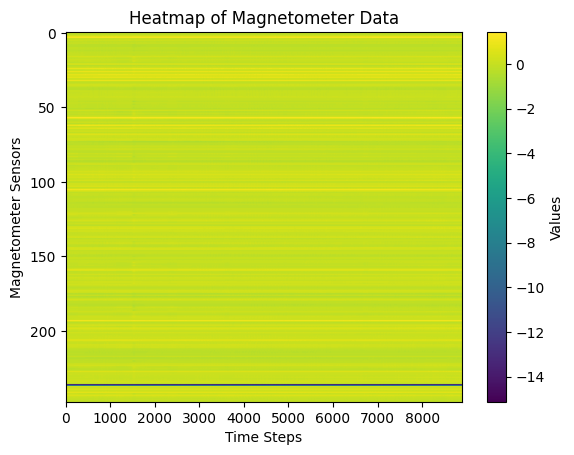

In [144]:
# Generate predictions (probabilities -- the output of the last layer)
print("Generate predictions for a random sample")

# Get a random index along the first axis
random_index = np.random.randint(test_data.shape[0])

# Extract the random sample
# random_sample = test_data[random_index, :, :]
# print(random_sample.shape)

random_sample = test_data[random_index]
true_class_index = test_labels[random_index]

predictions = model.predict(np.expand_dims(random_sample, axis=0))
# print(predictions)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the index to the corresponding task type
predicted_task_type = [
    key for key, value in task_types.items() if value == predicted_class_index][0]
true_task_type = [key for key, value in task_types.items()
                  if value == true_class_index][0]


print(f"Predicted Task Type: {predicted_task_type}")
print(f"True Task Type: {true_task_type}")

# matrix_data = np.squeeze(random_sample, axis=0)
plt.imshow(random_sample, aspect='auto', cmap='viridis')
plt.xlabel('Time Steps')
plt.ylabel('Magnetometer Sensors')
plt.title('Heatmap of Magnetometer Data')
plt.colorbar(label='Values')
plt.show()